# Fine Tuned BanglaBERT (csebuetnlp/banglabert)

In [1]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, EarlyStoppingCallback
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import matplotlib.pyplot as plt  # Importing matplotlib for plotting

# Load Dataset

In [2]:
train_data = pd.read_excel(r'E:\Bangla-Sentiment-Analysis\Bangla_Dataset\train_data_df.xlsx')
val_data = pd.read_excel(r'E:\Bangla-Sentiment-Analysis\Bangla_Dataset\val_data_df.xlsx')
test_data = pd.read_excel(r'E:\Bangla-Sentiment-Analysis\Bangla_Dataset\test_data_df.xlsx')

In [3]:
train_data.head(5)

,clean_sentence,Sentiment
0,একদম লো কোয়ালিটি টাইট দিলে ভিতরে কটকট শব্দ করে,Negative
1,ভালো পণ্য,Positive
2,বাজে একটা প্রডাকট লক গুলা ভালোনা খুবই নরমাল প্...,Negative
3,টা অর্ডার করছিলাম টাই পেয়েছি অনেক তারাতারি পে...,Positive
4,এটা আমি আগে দোকান থেকে কিনেছিলাম প্রায় বছর আছে...,Positive


In [4]:
# Sentiment Mapping
sentiment_mapping = {'Positive': 2, 'Neutral': 1, 'Negative': 0}

# Apply the mapping 
train_data['Sentiment'] = train_data['Sentiment'].map(sentiment_mapping)
val_data['Sentiment'] = val_data['Sentiment'].map(sentiment_mapping)
test_data['Sentiment'] = test_data['Sentiment'].map(sentiment_mapping)


# Load Fine Tuned Directory

In [5]:
fine_tune_dir = r'E:\Bangla-Sentiment-Analysis\Bangla_FineTuned_BERT'

In [6]:
# BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained(fine_tune_dir)

# Custom Dataset
class SentimentDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=184,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Dataloader 

In [7]:
# Prepare DataLoader
train_dataset = SentimentDataset(train_data['clean_sentence'].tolist(), train_data['Sentiment'].tolist())
val_dataset = SentimentDataset(val_data['clean_sentence'].tolist(), val_data['Sentiment'].tolist())
test_dataset = SentimentDataset(test_data['clean_sentence'].tolist(), test_data['Sentiment'].tolist())

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Initialize Model

In [8]:
model = BertForSequenceClassification.from_pretrained(fine_tune_dir, num_labels=3)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

# Optimizer
optimizer = AdamW(model.parameters(), lr=0.00001)

C:\Users\Rizvi\AppData\Roaming\Python\Python312\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Train Model

In [9]:
# Initialize lists to track losses
train_losses = []
val_losses = []

# Training function
def train_model(model, train_loader, val_loader, optimizer, num_epochs=10, patience=3):
    best_val_loss = float('inf')  # Initialize the best validation loss
    patience_counter = 0  # Counter to track how long validation loss has not improved

    model.train()
    for epoch in range(num_epochs):
        total_train_loss = 0
        model.train()  # Set the model to training mode

        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')
            labels = batch['labels'].to('cuda')

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_train_loss += loss.item()

            loss.backward()
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)  # Append training loss
        print(f'Epoch {epoch + 1}')
        print(f'Train Loss: {avg_train_loss}')

        # Validation
        model.eval()  # Set the model to evaluation mode
        total_val_loss = 0
        val_labels = []
        val_preds = []

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to('cuda')
                attention_mask = batch['attention_mask'].to('cuda')
                labels = batch['labels'].to('cuda')

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                total_val_loss += loss.item()

                preds = torch.argmax(outputs.logits, dim=-1)
                val_labels.extend(labels.cpu().numpy())
                val_preds.extend(preds.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)  # Append validation loss
        f1 = f1_score(val_labels, val_preds, average='weighted')
        precision = precision_score(val_labels, val_preds, average='weighted')
        recall = recall_score(val_labels, val_preds, average='weighted')
        accuracy = np.mean(np.array(val_labels) == np.array(val_preds))

        print(f'Validation Loss: {avg_val_loss}')
        print(f'Accuracy: {accuracy:.4f}, F1 Score: {f1}, Precision: {precision}, Recall: {recall}')

        # Early stopping logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0  # Reset patience counter if validation loss improves
            print("Validation loss improved, saving the model...")
            torch.save(model.state_dict(), 'best_fine_tuned_bangla_model.pt')  # Save the model if validation loss improves
        else:
            patience_counter += 1  # Increment the patience counter
            print(f'No improvement in validation loss for {patience_counter} epoch(s).')

        if patience_counter >= patience:
            print(f'Early stopping triggered after {patience_counter} epochs without improvement.')
            break  # Exit the training loop if patience has been exceeded

# Train the model 
train_model(model, train_loader, val_loader, optimizer, num_epochs=10, patience=2)

  0%|          | 0/2576 [00:00<?, ?it/s]C:\Users\Rizvi\AppData\Roaming\Python\Python312\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
100%|██████████| 2576/2576 [02:36<00:00, 16.42it/s]


Epoch 1
Train Loss: 0.6903794919117499
Validation Loss: 0.6840733990814146
Accuracy: 0.7270, F1 Score: 0.7103059721924159, Precision: 0.7063305398214236, Recall: 0.7270341207349081
Validation loss improved, saving the model...


100%|██████████| 2576/2576 [02:33<00:00, 16.74it/s]


Epoch 2
Train Loss: 0.6469232983892981
Validation Loss: 0.7025384014853127
Accuracy: 0.7192, F1 Score: 0.6993334122745497, Precision: 0.6986866674686973, Recall: 0.7191601049868767
No improvement in validation loss for 1 epoch(s).


100%|██████████| 2576/2576 [02:34<00:00, 16.71it/s]


Epoch 3
Train Loss: 0.6160135541533508
Validation Loss: 0.680864631429891
Accuracy: 0.7168, F1 Score: 0.7159533108080022, Precision: 0.7168160123904349, Recall: 0.7168117143251831
Validation loss improved, saving the model...


100%|██████████| 2576/2576 [02:34<00:00, 16.72it/s]


Epoch 4
Train Loss: 0.5806411203880568
Validation Loss: 0.7646875001201973
Accuracy: 0.7052, F1 Score: 0.6796207658975209, Precision: 0.6863457339485877, Recall: 0.7052079016438735
No improvement in validation loss for 1 epoch(s).


100%|██████████| 2576/2576 [02:34<00:00, 16.71it/s]


Epoch 5
Train Loss: 0.5464213947918821
Validation Loss: 0.712280386348785
Accuracy: 0.7118, F1 Score: 0.701736331412761, Precision: 0.7009898258804144, Recall: 0.711838651747479
No improvement in validation loss for 2 epoch(s).
Early stopping triggered after 2 epochs without improvement.


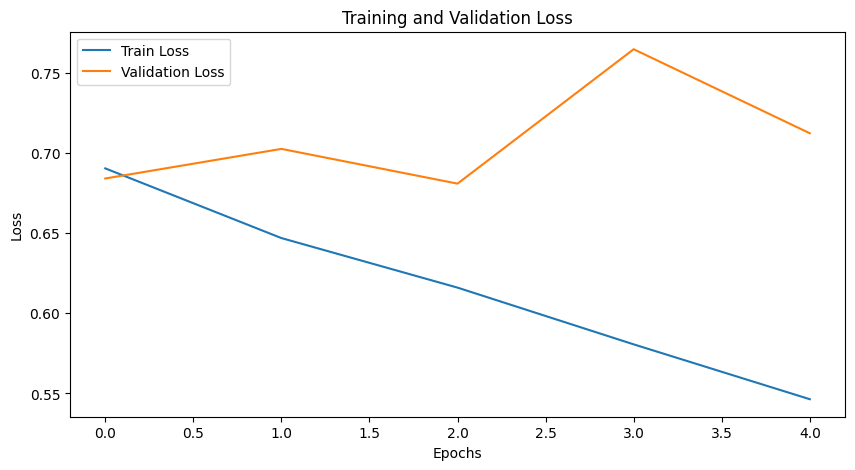

In [10]:
# Plot losses
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Test Model

In [11]:
# Load the best model state (the one with the lowest validation loss) before evaluating on the test set
model.load_state_dict(torch.load('best_fine_tuned_bangla_model.pt'))
model.eval()  

# Evaluation on Test Dataset

test_labels = []
test_preds = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        labels = batch['labels'].to('cuda')

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=-1)
        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(preds.cpu().numpy())

test_accuracy = np.mean(np.array(test_labels) == np.array(test_preds))
f_score = f1_score(test_labels, test_preds, average='weighted')
precision = precision_score(test_labels, test_preds, average='weighted')
recall = recall_score(test_labels, test_preds, average='weighted')

C:\Users\Rizvi\AppData\Local\Temp\ipykernel_12924\4018385208.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_fine_tuned_bangla_mod

--------------------------------------------------Test Set---------------------------------------------------------------------------
Evaluating on Test Dataset
Test Accuracy: 0.7272, F Score: 0.7269
Test Precision: 0.7278, Test Recall: 0.7272

Classification Report:
              precision    recall  f1-score   support

    Negative       0.79      0.73      0.76      2322
     Neutral       0.49      0.50      0.49      1488
    Positive       0.79      0.83      0.81      3150

    accuracy                           0.73      6960
   macro avg       0.69      0.69      0.69      6960
weighted avg       0.73      0.73      0.73      6960


Confusion Matrix:
[[1703  387  232]
 [ 297  737  454]
 [ 150  379 2621]]


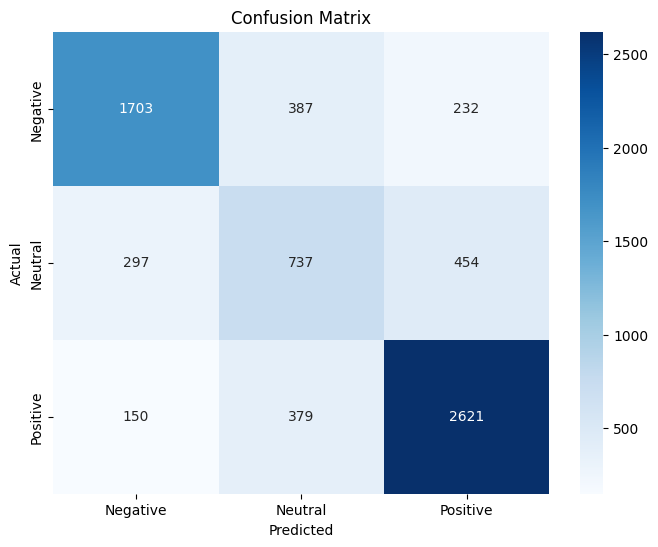

In [12]:
print("--------------------------------------------------Test Set---------------------------------------------------------------------------")
print("Evaluating on Test Dataset")
print(f"Test Accuracy: {test_accuracy:.4f}, F Score: {f_score:.4f}")
print(f"Test Precision: {precision:.4f}, Test Recall: {recall:.4f}")

# Generate classification report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=['Negative', 'Neutral', 'Positive']))

# Generate confusion matrix
cm = confusion_matrix(test_labels, test_preds)
print("\nConfusion Matrix:")
print(cm)

# Visualizing the confusion matrix 
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix")
plt.show()

